In [1]:
import numpy as np
import pandas as pd
import h5py
from chainconsumer import Chain, ChainConsumer, ChainConfig, PlotConfig
import matplotlib.pyplot as plt


def load_chain_with_weights(path, omega_col, sigma_col, weight_col="log_weight", burn_frac=0.3):
    """Load columns (omega_m, sigma8, log_weight) from a nautilus txt chain, apply burn, return samples + normalized weights."""
    with open(path, "r") as fh:
        header_tokens = fh.readline().lstrip("#").split()
    header_tokens = [tok for tok in header_tokens if "=" not in tok]

    col_sigma = header_tokens.index(sigma_col)
    col_omega = header_tokens.index(omega_col)
    col_w = header_tokens.index(weight_col)

    raw = np.loadtxt(path, comments="#", usecols=(col_omega, col_sigma, col_w))
    omega_raw, sigma_raw, logw_raw = raw[:, 0], raw[:, 1], raw[:, 2]

    mask = np.isfinite(omega_raw) & np.isfinite(sigma_raw) & np.isfinite(logw_raw)
    omega_raw, sigma_raw, logw_raw = omega_raw[mask], sigma_raw[mask], logw_raw[mask]

    burn_idx = int(len(logw_raw) * burn_frac)
    omega = omega_raw[burn_idx:]
    sigma = sigma_raw[burn_idx:]
    logw = logw_raw[burn_idx:]

    weights = np.exp(logw - np.max(logw))
    wnorm = weights / np.sum(weights)

    chain = np.vstack([omega, sigma]).T
    return chain, wnorm


def load_hdf5_chain_blobs(path, burn_frac=0.3):
    """Load omega_m, sigma_8, logl from sampler_status.hdf5 blobs_* and return chain + normalized weights."""
    all_blobs = []
    with h5py.File(path, "r") as f:
        sampler_group = f["sampler"]
        blob_keys = []
        for k in sampler_group.keys():
            if k.startswith("blobs_"):
                try:
                    idx = int(k.split("_")[1])
                except ValueError:
                    continue
                blob_keys.append((idx, k))
        blob_keys = [k for (_, k) in sorted(blob_keys)]
        for key in blob_keys:
            arr = sampler_group[key][:]
            all_blobs.append(arr)
    all_blobs = np.vstack(all_blobs)

    logl = all_blobs[:, 0]
    sigma_8 = all_blobs[:, 1]
    omega_m = all_blobs[:, 2]

    mask = np.isfinite(logl) & np.isfinite(sigma_8) & np.isfinite(omega_m)
    logl = logl[mask]
    sigma_8 = sigma_8[mask]
    omega_m = omega_m[mask]

    burn_idx = int(len(logl) * burn_frac)
    logl = logl[burn_idx:]
    sigma_8 = sigma_8[burn_idx:]
    omega_m = omega_m[burn_idx:]

    weights = np.exp(logl - np.max(logl))
    wnorm = weights / np.sum(weights)

    chain = np.vstack([omega_m, sigma_8]).T
    return chain, wnorm


def load_polychord_prior_chain(poly_path, header_path, omega_col_name, sigma_col_name, burn_frac=0.3):
    """Load omega_m, sigma_8, weights from a PolyChord prior file using a reference nautilus header."""
    with open(header_path, "r") as fh:
        header_tokens = fh.readline().lstrip("#").split()
    header_tokens = [tok for tok in header_tokens if "=" not in tok]
    param_tokens = [tok for tok in header_tokens if tok not in ("log_weight", "prior", "post")]

    name_to_idx = {tok.lower(): idx for idx, tok in enumerate(param_tokens)}
    omega_key = omega_col_name.lower()
    sigma_key = sigma_col_name.lower()
    if omega_key not in name_to_idx or sigma_key not in name_to_idx:
        raise ValueError(f"Could not find omega/sigma columns in header {header_path}")

    idx_omega = name_to_idx[omega_key]
    idx_sigma = name_to_idx[sigma_key]

    data = np.loadtxt(poly_path)
    expected_params = len(param_tokens)
    param_block = data[:, 2 : 2 + expected_params]
    if param_block.shape[1] != expected_params:
        raise ValueError(
            f"PolyChord column count mismatch: expected {expected_params} params, got {param_block.shape[1]}"
        )

    omega_raw = param_block[:, idx_omega]
    sigma_raw = param_block[:, idx_sigma]
    weights_raw = data[:, 0]

    burn_idx = int(len(weights_raw) * burn_frac)
    omega = omega_raw[burn_idx:]
    sigma = sigma_raw[burn_idx:]
    weights = weights_raw[burn_idx:]

    wnorm = weights / np.sum(weights)

    chain = np.vstack([omega, sigma]).T
    return chain, wnorm


In [2]:
# Paths
path_fidcorr2 = "/home/joannjones/cosmosis-standard-library/${OUTPUT_DIR}/pc__prior.txt"  # PolyChord prior output for fid_corr2
path_fidcorr_header = "/home/joannjones/cosmosis-standard-library/chain_fiducial.txt"  # header with column ordering
path_planck = "/home/joannjones/cosmosis-standard-library/fiducial_cmb_tp_external_R1006.txt"  # fiducial combined CMB posteriors
path_desy6 = "/home/joannjones/cosmosis-standard-library/32pt_wolensbin2_lin_lcdm_DV0723_R0723.txt"  # DESY6

# Column names per file (for the txt chains)
planck_cols = {
    "omega_col": "cosmological_parameters--omega_m",
    "sigma_col": "COSMOLOGICAL_PARAMETERS--SIGMA_8",
}
desy6_cols = {
    "omega_col": "cosmological_parameters--omega_m",
    "sigma_col": "COSMOLOGICAL_PARAMETERS--SIGMA_8",
}

# Load fid_corr2 from PolyChord prior output using fiducial header for column order
chain_fidcorr2, w_fidcorr2 = load_polychord_prior_chain(
    poly_path=path_fidcorr2,
    header_path=path_fidcorr_header,
    omega_col_name=planck_cols["omega_col"],
    sigma_col_name=planck_cols["sigma_col"],
    burn_frac=0.3,
)

# Load txt chains
chain_planck, w_planck = load_chain_with_weights(
    path_planck,
    omega_col=planck_cols["omega_col"],
    sigma_col=planck_cols["sigma_col"],
    burn_frac=0.3,
)

chain_desy6, w_desy6 = load_chain_with_weights(
    path_desy6,
    omega_col=desy6_cols["omega_col"],
    sigma_col=desy6_cols["sigma_col"],
    burn_frac=0.3,
)

print(
    "Loaded shapes:",
    chain_fidcorr2.shape,
    chain_planck.shape,
    chain_desy6.shape,
)


Loaded shapes: (350, 2) (24727, 2) (80986, 2)


Parameter $\Omega_m$ in chain new chain is not constrained


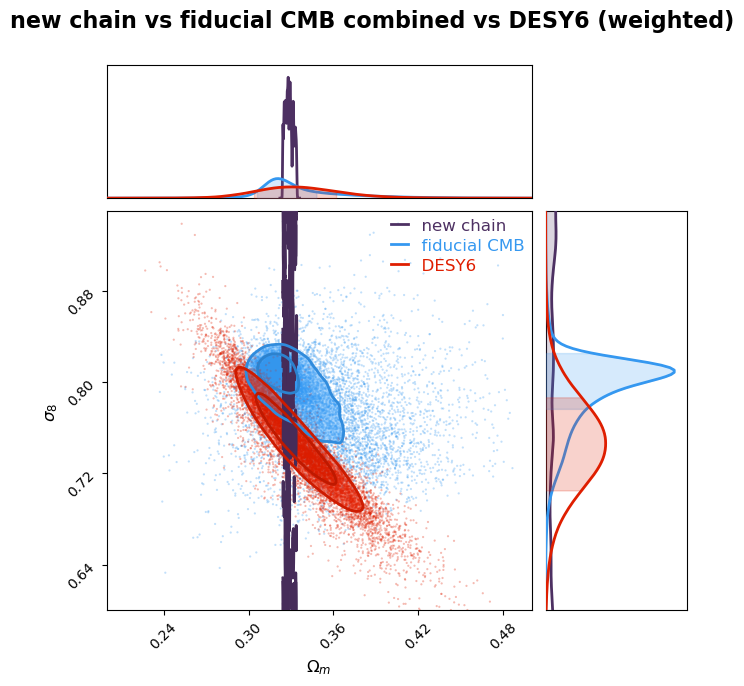

In [3]:
# Weighted posterior comparison for sigma8 vs omegam

# Build dataframes for ChainConsumer
columns = [r"$\Omega_m$", r"$\sigma_8$"]
df_fidcorr2 = pd.DataFrame(chain_fidcorr2, columns=columns)
df_planck = pd.DataFrame(chain_planck, columns=columns)
df_desy6 = pd.DataFrame(chain_desy6, columns=columns)

c = ChainConsumer()
c.add_chain(
    Chain(samples=df_fidcorr2, weights=w_fidcorr2, name="new chain", color="#4d3062", linewidth=2.0, shade_gradient=1)
)
c.add_chain(
    Chain(samples=df_planck, weights=w_planck, name="fiducial CMB", color="#3598F0", linewidth=2.0, shade_gradient=1)
)
c.add_chain(
    Chain(samples=df_desy6, weights=w_desy6, name="DESY6", color="#DF1E00", linewidth=2.0, shade_gradient=1)
)

c.set_plot_config(PlotConfig(flip=True, extents={r"$\sigma_8$": (0.6, 0.95), r"$\Omega_m$": (0.2, 0.5)}))
c.set_override(
    ChainConfig(
        shade_alpha=0.45,
        shade_gradient=0.1,
        sigmas=np.linspace(0, 1, 3).tolist(),
        plot_cloud=True,
    )
)
fig = c.plotter.plot()
fig.suptitle("new chain vs fiducial CMB combined vs DESY6 (weighted)", fontsize=16, fontweight="bold")
plt.savefig("chainconsumer_fiducial_fidcmb_desy6.png", dpi=300)
plt.show()